In [146]:
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from scipy.spatial.transform import Rotation as R
from asp_plot.jitter import read_linescan_csm_cam
from shapely.geometry import Point
from pyproj import Transformer

In [147]:
before1 = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
before2 = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
after1 = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
after2 = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

In [148]:
positions1, rotations1 = read_linescan_csm_cam(before1)
positions2, rotations2 = read_linescan_csm_cam(after1)

positions1 = np.array(positions1)
positions2 = np.array(positions2)
rotations1 = np.array(rotations1)
rotations2 = np.array(rotations2)

In [149]:
def ecef_to_wgs84(positions):
    transformer = Transformer.from_crs("EPSG:4978", "EPSG:4326")
    lons, lats, alts = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((lons, lats, alts))

def ecef_to_utm(positions, utm_zone="32604"):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{utm_zone}")
    lons, lats, alts = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((lons, lats, alts))

def rotation_matrix_to_euler_angles(r):
    r = R.from_matrix(r)
    return r.as_euler('xyz', degrees=True)

In [150]:
positions1_wgs84 = ecef_to_utm(positions1)
positions2_wgs84 = ecef_to_utm(positions2)

position_diffs = positions2 - positions1
diff_x = position_diffs[:, 0]
diff_y = position_diffs[:, 1]
diff_z = position_diffs[:, 2]
position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

euler_angles1 = np.array([rotation_matrix_to_euler_angles(r) for r in rotations1])
euler_angles2 = np.array([rotation_matrix_to_euler_angles(r) for r in rotations2])

angle_diffs = euler_angles2 - euler_angles1
diff_roll = angle_diffs[:, 0]
diff_pitch = angle_diffs[:, 1]
diff_yaw = angle_diffs[:, 2]

data = {
    'position1': [Point(x, y, z) for x, y, z in positions1_wgs84],
    'position2': [Point(x, y, z) for x, y, z in positions2_wgs84],
    'rotation1': [r for r in rotations1],
    'rotation2': [r for r in rotations2],
    'position_diff_magnitude': position_diff_magnitudes,
    'diff_x': diff_x,
    'diff_y': diff_y,
    'diff_z': diff_z,
    'diff_roll': diff_roll,
    'diff_pitch': diff_pitch,
    'diff_yaw': diff_yaw
}

df = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(df, geometry='position1')

gdf.set_crs(epsg=32604, inplace=True)


,position1,position2,rotation1,rotation2,position_diff_magnitude,diff_x,diff_y,diff_z,diff_roll,diff_pitch,diff_yaw
0,POINT Z (848347.46 -11343699.325 794800.977),POINT Z (848347.4604389553 -11343699.324593319...,"[[-0.020511218956818622, 0.9935414941512491, -...","[[-0.020511218956818622, 0.9935414941512491, -...",0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,POINT Z (848412.09 -11343581.789 794801.099),POINT Z (848412.0904974106 -11343581.789370397...,"[[-0.02055960223888892, 0.9935252742151726, -0...","[[-0.02055960223888892, 0.9935252742151726, -0...",0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,POINT Z (848476.72 -11343464.254 794801.221),POINT Z (848476.7201367153 -11343464.25383695 ...,"[[-0.020607978892427326, 0.9935090345342212, -...","[[-0.020607978892427326, 0.9935090345342212, -...",0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,POINT Z (848541.349 -11343346.718 794801.343),POINT Z (848541.3493567572 -11343346.717993122...,"[[-0.02065634886482004, 0.9934927751160441, -0...","[[-0.02065634886482004, 0.9934927751160441, -0...",0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,POINT Z (848605.978 -11343229.182 794801.465),POINT Z (848605.9781575646 -11343229.181838801...,"[[-0.020704712172599782, 0.9934764959635973, -...","[[-0.020704712172599782, 0.9934764959635973, -...",0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
1785,POINT Z (963027.812 -11133383.392 794990.478),POINT Z (963027.8122175931 -11133383.392474238...,"[[-0.0960943852045687, 0.9358895072069535, -0....","[[-0.0960943852045687, 0.9358895072069537, -0....",0.000000e+00,0.0,0.000000e+00,0.0,-5.329071e-14,2.664535e-14,0.000000e+00
1786,POINT Z (963091.665 -11133265.267 794990.569),POINT Z (963091.665391433 -11133265.267166961 ...,"[[-0.09613010933643246, 0.9358420820840139, -0...","[[-0.09613010933643246, 0.9358420820840142, -0...",0.000000e+00,0.0,0.000000e+00,0.0,-1.278977e-13,1.243450e-14,0.000000e+00
1787,POINT Z (963155.518 -11133147.142 794990.659),POINT Z (963155.5181133908 -11133147.141508587...,"[[-0.09616582624785869, 0.9357946397227959, -0...","[[-0.09616582624785869, 0.9357946397227962, -0...",0.000000e+00,0.0,0.000000e+00,0.0,-1.030287e-13,5.151435e-14,-5.684342e-14
1788,POINT Z (963219.37 -11133029.015 794990.749),POINT Z (963219.3703834885 -11133029.015498996...,"[[-0.09620153591436825, 0.9357471801239987, -0...","[[-0.09620153591436825, 0.9357471801239987, -0...",2.546585e-11,0.0,2.546585e-11,0.0,0.000000e+00,0.000000e+00,0.000000e+00


In [139]:
gdf.iloc[1000]

position1                  POINT Z (-78.40270437975387 2.302877700604259 ...
position2                  POINT Z (-78.40270155363349 2.3029285895257 79...
rotation1                  [[-0.06571522977223293, 0.9679788520267877, -0...
rotation2                  [[-0.06571818566930943, 0.9679786705506305, -0...
position_diff_magnitude                                             4.714358
diff_x                                                              1.203961
diff_y                                                              1.333895
diff_z                                                             -4.358483
diff_roll                                                          -0.000056
diff_pitch                                                          0.000033
diff_yaw                                                           -0.000178
Name: 1000, dtype: object

In [144]:
gdf.iloc[1000].position1.z

794914.1976673389

In [145]:
gdf.iloc[1000].position2.z

794918.7197848232

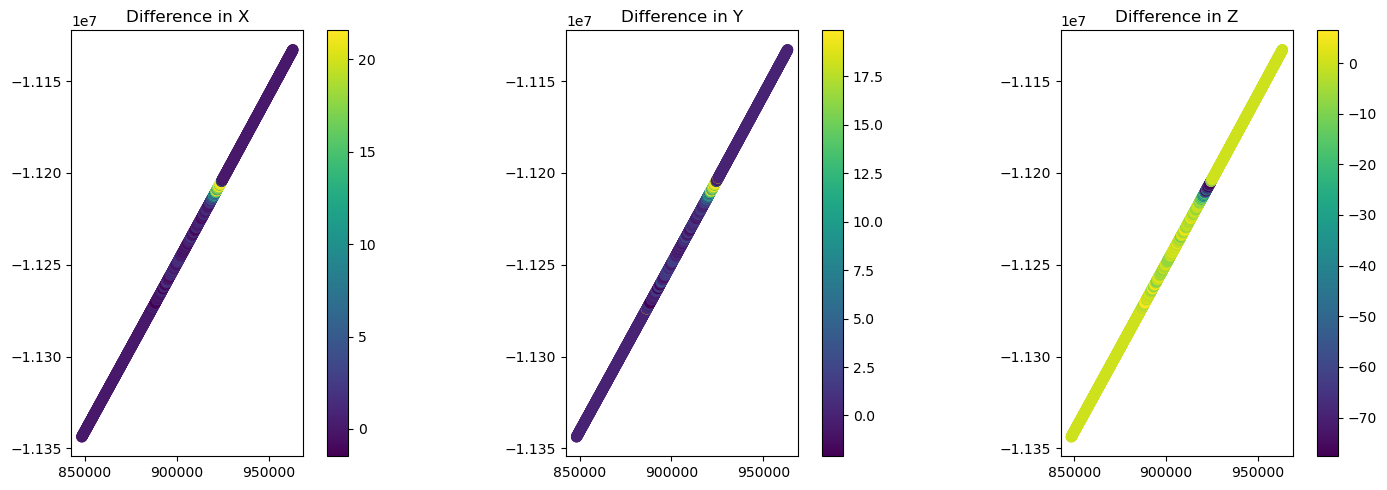

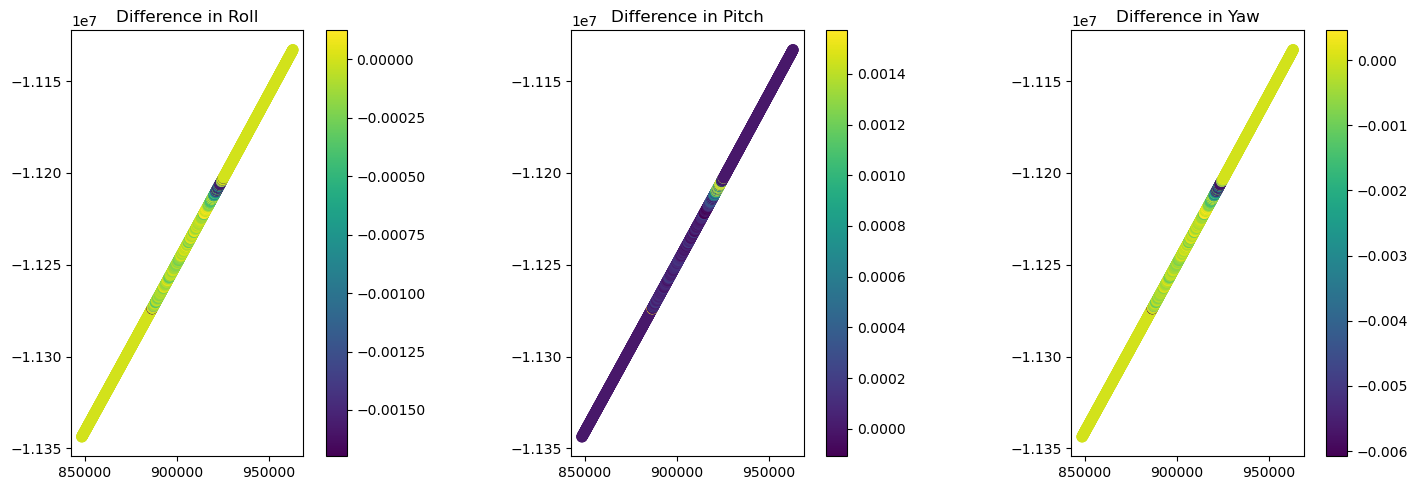

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='diff_x', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(diff_x, 1), vmax=np.percentile(diff_x, 99))
axes[0].set_title('Difference in X')

gdf.plot(column='diff_y', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(diff_y, 1), vmax=np.percentile(diff_y, 99))
axes[1].set_title('Difference in Y')

gdf.plot(column='diff_z', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(diff_z, 1), vmax=np.percentile(diff_z, 99))
axes[2].set_title('Difference in Z')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='diff_roll', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(diff_roll, 1), vmax=np.percentile(diff_roll, 99))
axes[0].set_title('Difference in Roll')

gdf.plot(column='diff_pitch', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(diff_pitch, 1), vmax=np.percentile(diff_pitch, 99))
axes[1].set_title('Difference in Pitch')

gdf.plot(column='diff_yaw', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(diff_yaw, 1), vmax=np.percentile(diff_yaw, 99))
axes[2].set_title('Difference in Yaw')

plt.tight_layout()
plt.show()